Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [27]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [28]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [29]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

## Helper Functions

In [30]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [31]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(True, 4273965.462644153)

In [32]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(True, 2135345.5132768503)

### Solution



This code implements a self-adaptive optimization algorithm using simulated annealing with a restart strategy to solve a defined cost function. It initializes a current solution and iteratively tweaks it while accepting new solutions based on their costs and a decreasing temperature. The algorithm adapts the intensity of changes based on recent improvements, allowing for aggressive tweaks when progress is made and moderating them when it stalls. It also monitors valid costs to terminate early if consecutive iterations yield the same result, improving efficiency. The best solution found across all restarts is tracked, and the cost progression is visualized.

This code is inspired by the lectures and course materials presented in the Computational Intelligence course (01URROV).



Restarts:  10%|█         | 1/10 [00:02<00:24,  2.70s/restart]

Stopping restart 0 early due to 500 iterations with the same cost.


Restarts:  20%|██        | 2/10 [00:05<00:20,  2.59s/restart]


Stopping restart 1 early due to 500 iterations with the same cost.


Restarts:  30%|███       | 3/10 [00:08<00:19,  2.74s/restart]13, 135.86iter/s]

Stopping restart 2 early due to 500 iterations with the same cost.


Restarts:  40%|████      | 4/10 [00:10<00:16,  2.69s/restart]

Stopping restart 3 early due to 500 iterations with the same cost.


Restarts:  50%|█████     | 5/10 [00:13<00:13,  2.74s/restart]

Stopping restart 4 early due to 500 iterations with the same cost.


Restarts:  60%|██████    | 6/10 [00:16<00:10,  2.70s/restart]

Stopping restart 5 early due to 500 iterations with the same cost.


Restarts:  70%|███████   | 7/10 [00:18<00:07,  2.63s/restart]

Stopping restart 6 early due to 500 iterations with the same cost.


Restarts:  80%|████████  | 8/10 [00:21<00:05,  2.62s/restart]

Stopping restart 7 early due to 500 iterations with the same cost.


Restarts:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/restart]

Stopping restart 8 early due to 500 iterations with the same cost.


Restarts: 100%|██████████| 10/10 [00:26<00:00,  2.70s/restart]


Stopping restart 9 early due to 500 iterations with the same cost.


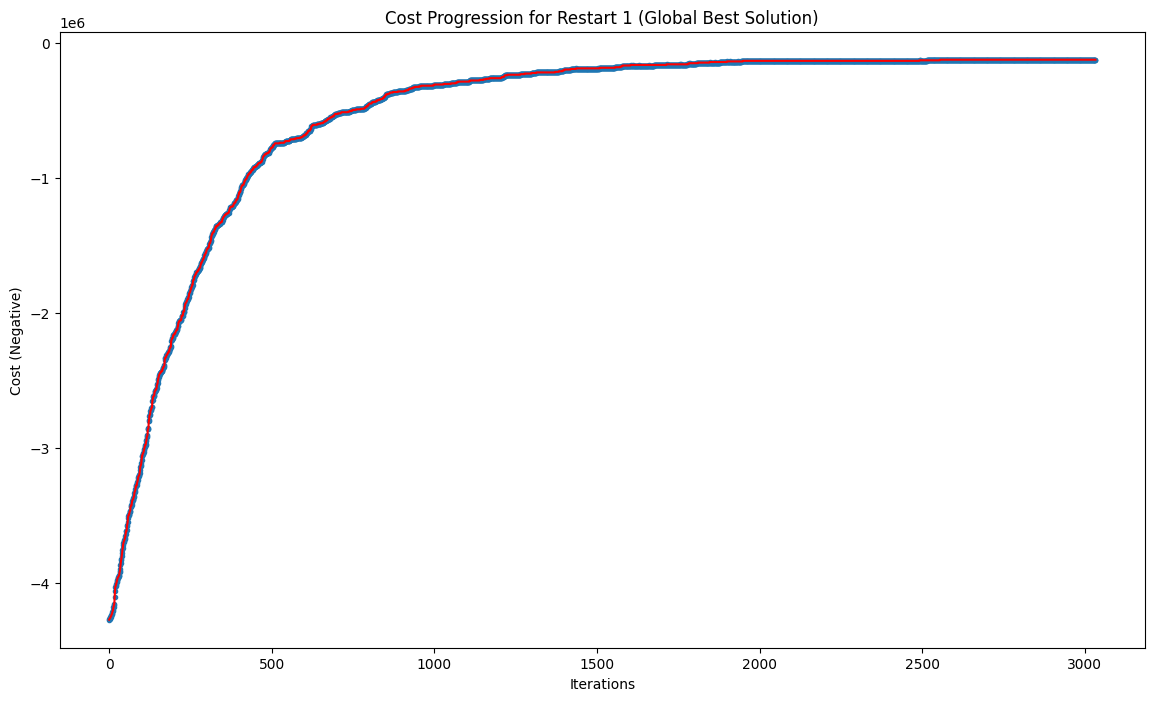

True 128578.22522265333


In [34]:
# Self-adaptive tweak, simulated annealing and restart

# Maximum number of iterations for tweak
max_iterations = 10000

# Tweak intensity
strength = 0.5

# Number of times the algorithm restarts
max_restarts = 10

# Buffer to track improvements (initializes with 0)
buffer = [0] * 5

# Parameters for simulated annealing
initial_temperature = 10  # Starting temperature
cooling_rate = 0.99       # Cooling rate to decrease temperature
min_temperature = 0.1     # Minimum temperature to stop cooling

# Maximum number of consecutive valid solutions with the same cost
max_same_cost_iterations = 500

# Acceptance Probability Function for Simulated Annealing
def acceptance_probability(old_cost, new_cost, temperature):
    if new_cost < old_cost:
        return 1.0  # Always accept better solutions
    return np.exp((old_cost - new_cost) / temperature)

# Initialize global best (solution, cost, and restart tracking)
global_best_solution = None
global_best_cost = float('inf')  # Start with a very high cost
best_restart = -1  # To track the restart that found the global best solution
global_history = []  # To store history of the best global restart

# Restart loop with progress bar  
for start in tqdm(range(max_restarts), desc="Restarts", unit="restart"):
    # Best solution for this restart - initializes with all sets 
    current_solution = np.full(NUM_SETS, True)
    current_cost = cost(current_solution)

    # Keep track of the best solution for this restart
    best_solution = current_solution.copy()
    best_cost = current_cost

    # Temperature initialization
    temperature = initial_temperature

    # History to track the cost progression for this restart
    history = [float(-cost(best_solution))]

    # Track valid costs for the last (max_same_cost_iterations) iterations
    last_valid_costs = []

    # Tweak iterations and progress bar update
    for iteration in tqdm(range(max_iterations), desc=f"Iterations in restart {start+1}", leave=False, unit="iter"):
        # Create a new solution starting from the current solution
        new_solution = current_solution.copy()

        # Randomly tweak the current solution by removing sets with a probability
        index = None
        while index is None or np.random.random() < strength:
            index = np.random.randint(0, NUM_SETS)
            if new_solution[index]:  # Only remove if it's already in the solution
                new_solution[index] = False

        # Calculate the cost of the new solution
        new_cost = cost(new_solution)

        # Append the cost of the current solution (negative cost for plotting)
        history.append(float(-new_cost))

        # Check if the new solution should be accepted (Simulated Annealing rule)
        if valid(new_solution):
            if acceptance_probability(current_cost, new_cost, temperature) > np.random.random():
                current_solution = new_solution.copy()  # Accept the new solution
                current_cost = new_cost

                # Update the best solution for this restart if the new solution is better
                if new_cost < best_cost:
                    best_solution = new_solution.copy()
                    best_cost = new_cost
                    buffer.append(1)  # Mark as improvement
                else:
                    buffer.append(0)  # No improvement
            else:
                buffer.append(0)  # No improvement

            # Keep track of the valid costs
            last_valid_costs.append(new_cost)
            if len(last_valid_costs) > max_same_cost_iterations:
                last_valid_costs.pop(0)  # Keep only the last (max_same_cost_iterations) valid costs

            # If the last (max_same_cost_iterations) valid solutions have the same cost, stop this restart
            if len(last_valid_costs) == max_same_cost_iterations and len(set(last_valid_costs)) == 1:
                print(f"Stopping restart {start} early due to {max_same_cost_iterations} iterations with the same cost.")
                break
        else:
            buffer.append(0)  # No improvement

        # Keep the buffer size limited to the last 5 results
        buffer = buffer[-5:]

        # Adjust tweak strength based on buffer results (1/5 rule)
        if sum(buffer) == 0:  # No improvements in the last 5 iterations
            strength = max(strength / 1.2, 0.1)  # Decrease, but keep it above a threshold
        elif sum(buffer) > 1:  # More than one improvement in the buffer
            strength = min(strength * 1.2, 0.7)  # Increase, but keep it under a threshold

        # Cool down the temperature (reduce exploration according to fitness)
        if sum(buffer) == 0:  # No improvements in last 5 iterations
            temperature = max(temperature * cooling_rate ** 2, min_temperature)
        else:  # Frequent improvements
            temperature = max(temperature * cooling_rate, min_temperature)

    # After the restart, check if the current restart's best solution is better than the global best
    if best_cost < global_best_cost:
        global_best_solution = best_solution.copy()  # Update global best solution
        global_best_cost = best_cost  # Update global best cost
        best_restart = start  # Track which restart produced the global best
        global_history = history.copy()  # Save the history of this restart

# Plot the cost progression for the restart that produced the global best solution
plt.figure(figsize=(14,8))
plt.plot(
    range(len(global_history)),
    list(accumulate(global_history, max)),
    color='red',
)

_ = plt.scatter(range(len(global_history)), global_history, marker=".")
plt.xlabel("Iterations")
plt.ylabel("Cost (Negative)")
plt.title(f"Cost Progression for Restart {best_restart} (Global Best Solution)")
plt.show()

# After the restarts, print the best solution and its cost
print(valid(global_best_solution), cost(global_best_solution))
